# 03 - Merton Jump Diffusion Model

## 0 - Setup Ambiente

In [12]:
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Imposto la root del progetto a partire dalla posizione di questo file
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
DATA_RESULTS = PROJECT_ROOT / "data" / "results"
DATA_RESULTS.mkdir(parents=True, exist_ok=True)

# Aggiungo la cartella src al path per poter importare i moduli personalizzati
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

In [13]:
import importlib, merton_jd
importlib.reload(merton_jd) # per ricaricare il modulo dopo averlo modificato
from merton_jd import JDParams, simulate_merton_jd, price_euro_call_mc_jd, discounted_martingale_error, merton_cf_call
from bsm import bs_price, bs_greeks, implied_vol
from utils_plot import plot_paths

## 1 - Test con BSM

In [14]:
S0, K, T, r, q, sigma = 100.0, 100.0, 1.0, 0.02, 0.00, 0.20 # dati di input
call_bsm = bs_price(S0, K, T, r, sigma, q, kind="call") # atteso ≈ 8.9160
put_bsm  = bs_price(S0, K, T, r, sigma, q, kind="put") # atteso ≈ 6.8051
print(f"Call BSM ≈ {call_bsm:.6f}")  # atteso ≈ 8.9160
print(f"Put  BSM ≈ {put_bsm:.6f}") # atteso ≈ 6.8051

Call BSM ≈ 8.916037
Put  BSM ≈ 6.935905


## 2 - Check con formula chiusa di Merton (λ=0 → BSM)

In [15]:
params_l0 = JDParams(sigma=0.2, lam=0.0, mu_J=-0.1, sigma_J=0.25) # λ=0 → BSM
cf_l0 = merton_cf_call(S0, K, T, r, q, params_l0, trunc=0) # formula chiusa Merton con λ=0
bs = bs_price(S0, K, T, r, params_l0.sigma, q, kind="call") # BSM
print(f"Call Merton (λ=0) ≈ {cf_l0:.6f}") # atteso ≈ 8.9160
print(f"Call BSM            ≈ {bs:.6f}") # atteso ≈ 8.9160
print(f"Diff ≈ {abs(cf_l0 - bs):.6f}") # atteso ≈ 0.0000

Call Merton (λ=0) ≈ 8.916037
Call BSM            ≈ 8.916037
Diff ≈ 0.000000


## 3 - Valutazione closed - form Merton

In [18]:
params = JDParams(sigma=0.2, lam=0.6, mu_J=-0.10, sigma_J=0.25) # parametri Merton JD
cf_price = merton_cf_call(S0, K, T, r, q, params, trunc=60) # formula chiusa Merton
print(f"Call Merton (λ=0.6) ≈ {cf_price:.6f}") # atteso ≈ 10.36

Call Merton (λ=0.6) ≈ 10.361327


## 3.1 Simulazione di traiettorie JD

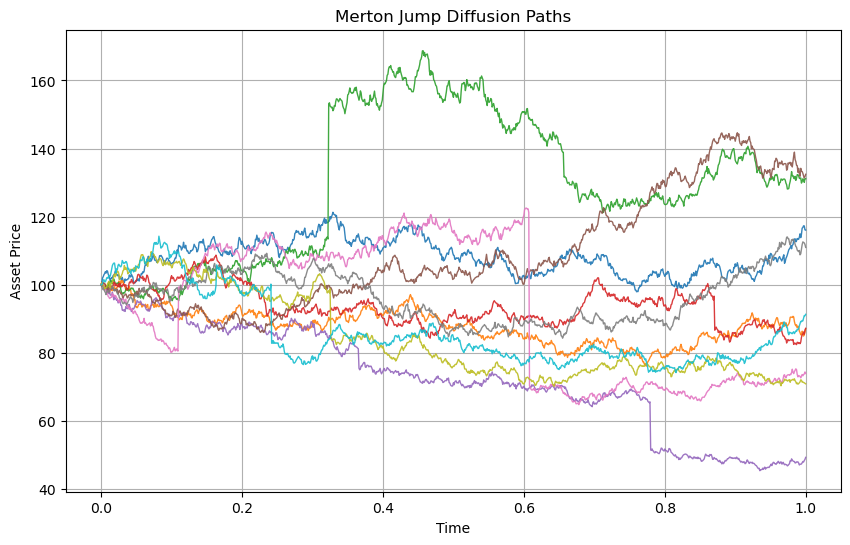

((10, 1001), (1001,))

In [22]:
# import della libreria per visualizzazione grafici
from utils_plot import plot_paths
# Parametri per il grafico
S0, T, r, q = 100.0, 1.0, 0.02, 0.00
# Parametri del modello di Merton Jump Diffusion
params = JDParams(sigma=0.2, lam=0.6, mu_J=-0.10, sigma_J=0.25)

N = 1000 # numero di passi temporali
M = 10   # numero di traiettorie da simulare
SEED = 42 # seme per la riproducibilità

t, S_paths = simulate_merton_jd(S0=S0, r=r, q=q, params=params, T=T, N=N, M=M, seed=SEED, antithetic=False) # simulo traiettorie
plot_paths(t, S_paths, title="Merton Jump Diffusion Paths", xlabel="Time", ylabel="Asset Price")
plt.show()
S_paths.shape, t.shape


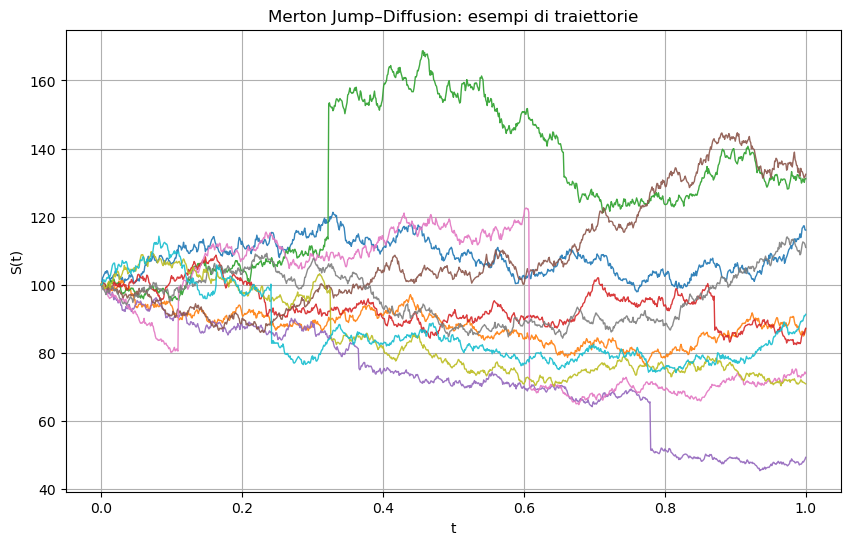

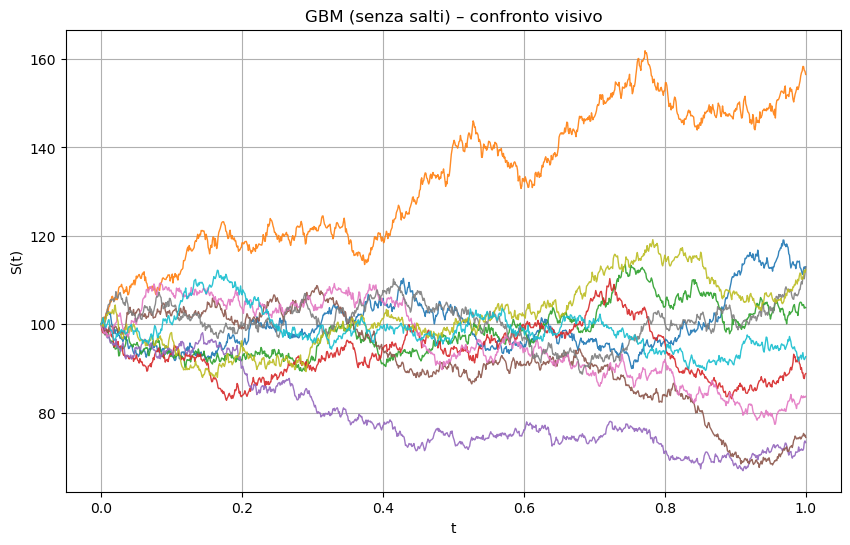

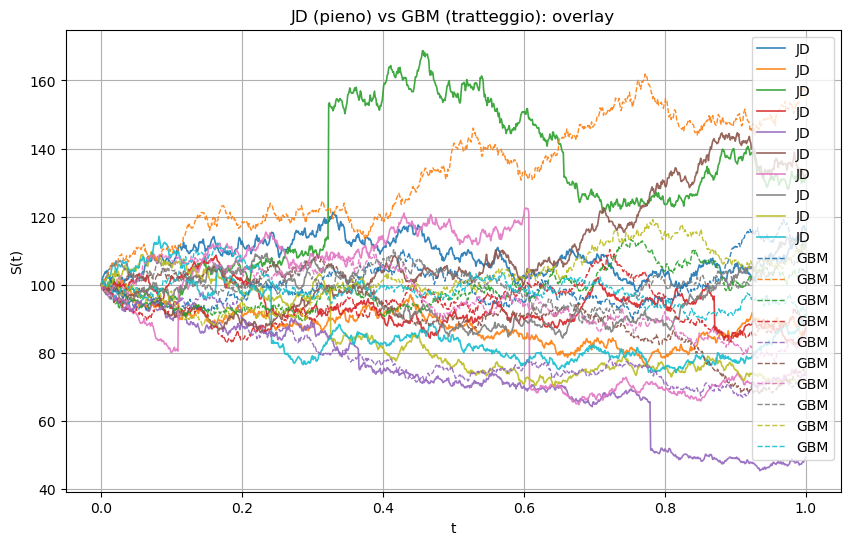

In [26]:
# Usa i tuoi moduli
from gbm import simulate_gbm
from utils_plot import plot_paths
import matplotlib.pyplot as plt
import numpy as np

# --- GBM risk–neutral: mu = r - q ---
mu_gbm = r - q
t_gbm, S_gbm = simulate_gbm(
    S0=S0, mu=mu_gbm, sigma=params.sigma,
    T=T, N=N, M=M, seed=SEED
)

# 1) Tracce JD (già simulate nella cella precedente: t, S_paths)
plot_paths(
    t=t,
    X=S_paths,
    n_paths=M,
    title="Merton Jump–Diffusion: esempi di traiettorie",
    xlabel="t", ylabel="S(t)",
    save_path=None,  # opzionale: metti un path per salvare
    alpha=0.9
)

# 2) Tracce GBM (stessi parametri di diffusione, niente salti)
plot_paths(
    t=t_gbm,
    X=S_gbm,
    n_paths=M,
    title="GBM (senza salti) – confronto visivo",
    xlabel="t", ylabel="S(t)",
    save_path=None,
    alpha=0.9
)

# 3) (Opzionale) Overlay JD vs GBM nella stessa figura (matplotlib "puro")
plt.figure(figsize=(10, 6))
plt.plot(t, S_paths[:M].T, lw=1.2, alpha=0.9, label="JD")
plt.plot(t_gbm, S_gbm[:M].T, "--", lw=1.0, alpha=0.9, label="GBM")
plt.title("JD (pieno) vs GBM (tratteggio): overlay")
plt.xlabel("t"); plt.ylabel("S(t)")
plt.grid(True); plt.legend()
plt.show()
